# 🎯 Thompson Sampling Convergence Analysis

**ผู้เขียน**: Hamdee Naseng  
**วันที่**: 3 พฤศจิกายน 2025  
**วัตถุประสงค์**: ศึกษาการ Converge ของ Thompson Sampling

---

## 🎯 โค้ดนี้ทำอะไร?

### 📊 Thompson Sampling Convergence

**คำถาม**: Thompson Sampling จะหา optimal arm ได้เร็วแค่ไหน?

**วิธีการ**:
- ใช้ **Thompson Sampling** กับ 3 bandits (p = 0.2, 0.25, 0.3)
- รันทั้งหมด **100,000 iterations**
- Plot **Cumulative Average CTR** (Log scale)
- ดูว่าเมื่อไหร่จะ converge ไปที่ optimal arm (p = 0.3)

**ความท้าทาย**:
- 🔴 Bandits มีค่า p ใกล้เคียงกัน (0.2, 0.25, 0.3)
- 🔴 ยากกว่าปกติที่จะแยกว่า arm ไหนดีกว่ากัน
- 🔴 ต้องใช้ samples เยอะกว่าถึงจะแน่ใจ

---

## 🔑 Key Concepts:

### 1. **Thompson Sampling (Beta-Bernoulli)**
```
แต่ละรอบ:
  1. Sample θᵢ ~ Beta(aᵢ, bᵢ) สำหรับแต่ละ arm i
  2. เลือก arm j = argmax(θᵢ)
  3. Pull arm j → ได้ reward x (0 หรือ 1)
  4. Update: aⱼ += x, bⱼ += (1-x)
```

### 2. **Convergence คืออะไร?**
- Algorithm **converge** แปลว่า Cumulative Average CTR → optimal p
- ยิ่ง converge เร็ว → Algorithm ยิ่งดี
- Log scale ช่วยเห็นพฤติกรรมช่วงแรก

### 3. **Cumulative Average**
```
Cumulative Average at time t:
  avg(t) = (reward₁ + reward₂ + ... + rewardₜ) / t
```

### 4. **เปรียบเทียบกับ Epsilon-Greedy**
- **Thompson Sampling**: Auto-adaptive, no parameter tuning
- **Epsilon-Greedy**: ต้องตั้ง ε เอง

---

## 🚀 สิ่งที่จะได้เรียนรู้:

1. ✅ Thompson Sampling converge อย่างไร
2. ✅ ผลของ arms ที่มีค่า p ใกล้เคียงกัน
3. ✅ การใช้ Log scale วิเคราะห์ convergence
4. ✅ เปรียบเทียบ performance กับ true probabilities

---

## 📦 Step 1: Import และตั้งค่า

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ตั้งค่า font สำหรับภาษาไทย
import matplotlib.font_manager as fm

font_path = '../../font/Prompt/Prompt-Regular.ttf'
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)
font_name = font_prop.get_name()

plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

print("✅ Import สำเร็จ!")
print(f"✅ ตั้งค่า Font ภาษาไทยเป็น '{font_name}' เรียบร้อย")

✅ Import สำเร็จ!
✅ ตั้งค่า Font ภาษาไทยเป็น 'Prompt' เรียบร้อย


## 🎰 Step 2: สร้าง Bandit Class (Beta-Bernoulli)

Class นี้ใช้ **Beta Distribution** เป็น posterior สำหรับ Thompson Sampling

In [3]:
class Bandit:
    """
    Bayesian Bandit สำหรับ Thompson Sampling
    
    ใช้ Beta Distribution เป็น posterior:
    - a, b: พารามิเตอร์ของ Beta(a, b)
    - เริ่มต้น: Beta(1, 1) = Uniform(0, 1)
    """
    def __init__(self, p):
        self.p = p      # True probability (ที่เราไม่รู้)
        self.a = 1      # Beta parameter a (wins)
        self.b = 1      # Beta parameter b (losses)
        self.N = 0      # จำนวนครั้งที่ pull
    
    def pull(self):
        """Pull arm และได้ reward (0 หรือ 1)"""
        return np.random.random() < self.p
    
    def sample(self):
        """Sample จาก Beta posterior
        
        Thompson Sampling:
        - Sample θ ~ Beta(a, b)
        - θ คือ ค่าประมาณของ true probability
        """
        return np.random.beta(self.a, self.b)
    
    def update(self, x):
        """Update Beta posterior
        
        Bayesian Update:
        - ถ้า x = 1 (win): a += 1
        - ถ้า x = 0 (loss): b += 1
        """
        self.a += x
        self.b += 1 - x
        self.N += 1
    
    def __repr__(self):
        return f"Bandit(p={self.p:.2f}, a={self.a}, b={self.b}, N={self.N})"

print("✅ สร้าง Bandit class เรียบร้อย!")
print("\n💡 Bandit จะ:")
print("   1. Sample θ ~ Beta(a, b) → ค่าประมาณของ p")
print("   2. Pull → ได้ reward (0 หรือ 1)")
print("   3. Update → a += win, b += loss")
print("   4. Beta posterior จะแคบลง → เข้าใกล้ true p")

✅ สร้าง Bandit class เรียบร้อย!

💡 Bandit จะ:
   1. Sample θ ~ Beta(a, b) → ค่าประมาณของ p
   2. Pull → ได้ reward (0 หรือ 1)
   3. Update → a += win, b += loss
   4. Beta posterior จะแคบลง → เข้าใกล้ true p


## 🧪 Step 3: ทดสอบ Bandit

มาดูว่า Bandit ทำงานอย่างไร

In [4]:
# สร้าง bandit ทดสอบ (true p = 0.3)
test_bandit = Bandit(0.3)

print("🎰 ทดสอบ Bandit (true p = 0.3)\n")
print(f"เริ่มต้น: {test_bandit}")
print(f"Sample 5 ครั้งจาก Beta({test_bandit.a}, {test_bandit.b}):")

for i in range(5):
    theta = test_bandit.sample()
    print(f"  Sample {i+1}: θ = {theta:.3f}")

print("\n🎯 Pull และ Update 10 ครั้ง:")
for i in range(10):
    reward = test_bandit.pull()
    test_bandit.update(reward)
    print(f"  Round {i+1}: reward = {reward}, Beta({test_bandit.a}, {test_bandit.b})")

print(f"\n📊 หลัง 10 ครั้ง: {test_bandit}")
print(f"   Estimated p = {test_bandit.a / (test_bandit.a + test_bandit.b):.3f}")
print(f"   True p = {test_bandit.p:.3f}")

print("\n💡 สังเกต:")
print("  - เริ่มต้น Beta(1, 1) → Sample ได้ทุกค่าระหว่าง 0-1")
print("  - หลังจาก update → Beta posterior แคบลง")
print("  - Estimated p เข้าใกล้ true p (0.3)")

🎰 ทดสอบ Bandit (true p = 0.3)

เริ่มต้น: Bandit(p=0.30, a=1, b=1, N=0)
Sample 5 ครั้งจาก Beta(1, 1):
  Sample 1: θ = 0.263
  Sample 2: θ = 0.186
  Sample 3: θ = 0.496
  Sample 4: θ = 0.069
  Sample 5: θ = 0.899

🎯 Pull และ Update 10 ครั้ง:
  Round 1: reward = True, Beta(2, 1)
  Round 2: reward = False, Beta(2, 2)
  Round 3: reward = False, Beta(2, 3)
  Round 4: reward = False, Beta(2, 4)
  Round 5: reward = False, Beta(2, 5)
  Round 6: reward = False, Beta(2, 6)
  Round 7: reward = False, Beta(2, 7)
  Round 8: reward = True, Beta(3, 7)
  Round 9: reward = False, Beta(3, 8)
  Round 10: reward = False, Beta(3, 9)

📊 หลัง 10 ครั้ง: Bandit(p=0.30, a=3, b=9, N=10)
   Estimated p = 0.250
   True p = 0.300

💡 สังเกต:
  - เริ่มต้น Beta(1, 1) → Sample ได้ทุกค่าระหว่าง 0-1
  - หลังจาก update → Beta posterior แคบลง
  - Estimated p เข้าใกล้ true p (0.3)


## 🏃 Step 4: สร้างฟังก์ชัน run_experiment

ฟังก์ชันนี้จะรัน Thompson Sampling และวิเคราะห์การ converge

In [5]:
def run_experiment(p1, p2, p3, N):
    """
    รัน Thompson Sampling experiment
    
    Parameters:
    -----------
    p1, p2, p3 : float
        True probabilities ของแต่ละ arm
    N : int
        จำนวนรอบ
    
    Returns:
    --------
    cumulative_average_ctr : array
        Cumulative average CTR เมื่อเวลาผ่านไป
    """
    # สร้าง 3 bandits
    bandits = [Bandit(p1), Bandit(p2), Bandit(p3)]
    
    # เก็บ rewards
    data = np.empty(N)
    
    print(f"\n🎯 เริ่มการทดลอง Thompson Sampling")
    print(f"   Arm 1: p = {p1}")
    print(f"   Arm 2: p = {p2}")
    print(f"   Arm 3: p = {p3} ⭐ (Optimal)")
    print(f"   จำนวนรอบ: {N:,}\n")
    
    for i in range(N):
        # Thompson Sampling
        # 1. Sample จาก posterior ของแต่ละ arm
        # 2. เลือก arm ที่มี sample สูงสุด
        j = np.argmax([b.sample() for b in bandits])
        
        # Pull arm ที่เลือก
        x = bandits[j].pull()
        bandits[j].update(x)
        
        # เก็บข้อมูล
        data[i] = x
    
    # คำนวณ cumulative average CTR
    cumulative_average_ctr = np.cumsum(data) / (np.arange(N) + 1)
    
    # แสดงผลลัพธ์
    print("📊 ผลลัพธ์:")
    for i, b in enumerate(bandits):
        estimated_p = b.a / (b.a + b.b) if (b.a + b.b) > 0 else 0
        is_best = " ⭐" if i == 2 else ""
        print(f"   Arm {i+1}: true={b.p:.2f}, estimated={estimated_p:.4f}, pulls={b.N:,}{is_best}")
    
    print(f"\n   Final Cumulative Average CTR: {cumulative_average_ctr[-1]:.4f}")
    print(f"   Optimal CTR (p3): {p3:.4f}")
    print(f"   Gap: {p3 - cumulative_average_ctr[-1]:.4f}")
    
    # วาดกราฟ
    plt.figure(figsize=(14, 7))
    
    plt.plot(cumulative_average_ctr, linewidth=2, label='Cumulative Average CTR', color='blue')
    plt.plot(np.ones(N)*p1, linestyle='--', alpha=0.7, label=f'Arm 1: p={p1}', color='red')
    plt.plot(np.ones(N)*p2, linestyle='--', alpha=0.7, label=f'Arm 2: p={p2}', color='orange')
    plt.plot(np.ones(N)*p3, linestyle='--', alpha=0.7, label=f'Arm 3: p={p3} (Optimal)', color='green')
    
    plt.xlabel('Iteration (Log Scale)', fontsize=12)
    plt.ylabel('Cumulative Average CTR', fontsize=12)
    plt.title('Thompson Sampling Convergence Analysis', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    plt.xscale('log')  # Log scale เพื่อเห็นพฤติกรรมช่วงแรก
    plt.ylim((0, 1))
    plt.tight_layout()
    plt.show()
    
    return cumulative_average_ctr

print("✅ สร้างฟังก์ชัน run_experiment เรียบร้อย!")

✅ สร้างฟังก์ชัน run_experiment เรียบร้อย!


## 🧪 Step 5: รัน Experiment (100,000 iterations)

มาดูว่า Thompson Sampling จะ converge อย่างไร

**ความท้าทาย**: Arms มีค่า p ใกล้เคียงกัน (0.2, 0.25, 0.3)


🎯 เริ่มการทดลอง Thompson Sampling
   Arm 1: p = 0.2
   Arm 2: p = 0.25
   Arm 3: p = 0.3 ⭐ (Optimal)
   จำนวนรอบ: 100,000

📊 ผลลัพธ์:
   Arm 1: true=0.20, estimated=0.2041, pulls=243
   Arm 2: true=0.25, estimated=0.2030, pulls=195
   Arm 3: true=0.30, estimated=0.3046, pulls=99,562 ⭐

   Final Cumulative Average CTR: 0.3041
   Optimal CTR (p3): 0.3000
   Gap: -0.0041
📊 ผลลัพธ์:
   Arm 1: true=0.20, estimated=0.2041, pulls=243
   Arm 2: true=0.25, estimated=0.2030, pulls=195
   Arm 3: true=0.30, estimated=0.3046, pulls=99,562 ⭐

   Final Cumulative Average CTR: 0.3041
   Optimal CTR (p3): 0.3000
   Gap: -0.0041


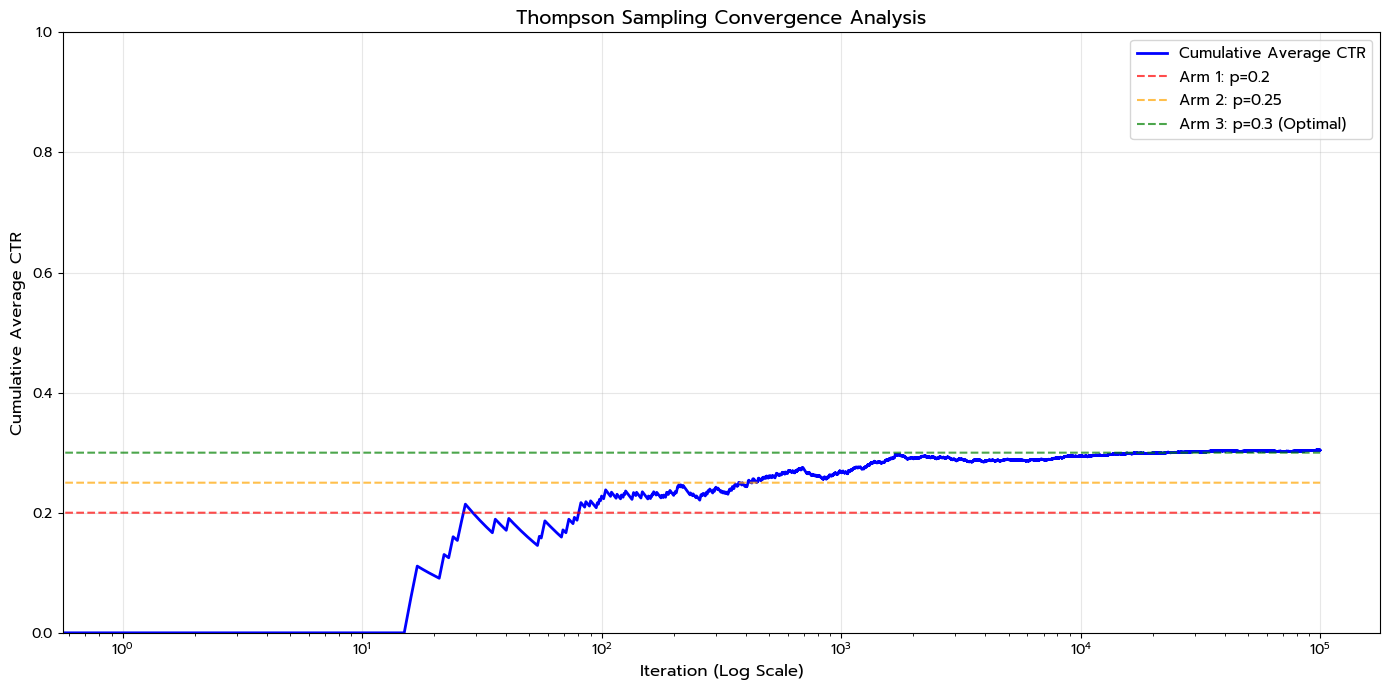


💡 สังเกตจากกราฟ (Log Scale):
  - ช่วง 1-100 iterations: สุ่มมาก → CTR กระเด้ง
  - ช่วง 100-1,000: เริ่มเรียนรู้ → CTR ค่อย ๆ เข้าใกล้ p3
  - ช่วง 1,000-10,000: เกือบ converge → CTR ใกล้ p3
  - หลัง 10,000: Converged → CTR ≈ p3 (0.3)

  🎯 Thompson Sampling เรียนรู้และ converge ไปที่ optimal arm!


In [6]:
# รัน experiment
cumulative_avg = run_experiment(p1=0.2, p2=0.25, p3=0.3, N=100000)

print("\n💡 สังเกตจากกราฟ (Log Scale):")
print("  - ช่วง 1-100 iterations: สุ่มมาก → CTR กระเด้ง")
print("  - ช่วง 100-1,000: เริ่มเรียนรู้ → CTR ค่อย ๆ เข้าใกล้ p3")
print("  - ช่วง 1,000-10,000: เกือบ converge → CTR ใกล้ p3")
print("  - หลัง 10,000: Converged → CTR ≈ p3 (0.3)")
print("\n  🎯 Thompson Sampling เรียนรู้และ converge ไปที่ optimal arm!")

## 📊 Step 6: วิเคราะห์ Convergence Speed

มาดูว่า Thompson Sampling converge เร็วแค่ไหน


🎯 Convergence Analysis:
   Converge point: 1,600 iterations
   CTR at convergence: 0.2904
   Gap from optimal: 0.0096
   Final CTR: 0.3041
   Final gap: 0.0041


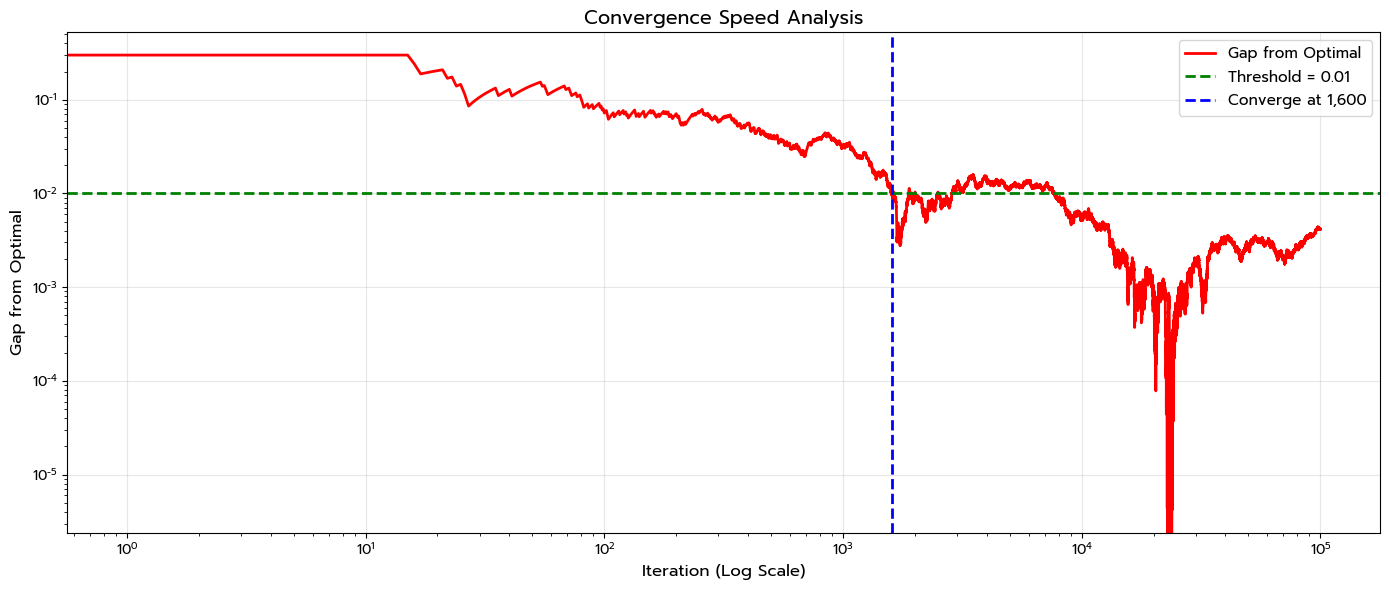


💡 สังเกต:
  - Gap ลดลงเรื่อย ๆ เมื่อเวลาผ่านไป
  - Log scale แสดงให้เห็นว่า gap ลดลงแบบ exponential
  - หลังจาก converge → gap เกือบเป็น 0


In [7]:
# หาจุดที่ converge (gap < 0.01)
optimal_p = 0.3
gap = np.abs(cumulative_avg - optimal_p)
converge_threshold = 0.01

# หาจุดแรกที่ gap < threshold และคงที่
converged_indices = np.where(gap < converge_threshold)[0]

if len(converged_indices) > 0:
    converge_point = converged_indices[0]
    print(f"\n🎯 Convergence Analysis:")
    print(f"   Converge point: {converge_point:,} iterations")
    print(f"   CTR at convergence: {cumulative_avg[converge_point]:.4f}")
    print(f"   Gap from optimal: {gap[converge_point]:.4f}")
    print(f"   Final CTR: {cumulative_avg[-1]:.4f}")
    print(f"   Final gap: {gap[-1]:.4f}")
else:
    print("\n⚠️ ยังไม่ converge ภายใน threshold ที่กำหนด")

# วาดกราฟ gap
plt.figure(figsize=(14, 6))

plt.plot(gap, linewidth=2, color='red', label='Gap from Optimal')
plt.axhline(converge_threshold, linestyle='--', color='green', linewidth=2, label=f'Threshold = {converge_threshold}')

if len(converged_indices) > 0:
    plt.axvline(converge_point, linestyle='--', color='blue', linewidth=2, label=f'Converge at {converge_point:,}')

plt.xlabel('Iteration (Log Scale)', fontsize=12)
plt.ylabel('Gap from Optimal', fontsize=12)
plt.title('Convergence Speed Analysis', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()

print("\n💡 สังเกต:")
print("  - Gap ลดลงเรื่อย ๆ เมื่อเวลาผ่านไป")
print("  - Log scale แสดงให้เห็นว่า gap ลดลงแบบ exponential")
print("  - หลังจาก converge → gap เกือบเป็น 0")

## 🆚 Step 7: เปรียบเทียบกับ Arms ที่แตกต่างกันชัดเจน

มาดูว่าถ้า arms แตกต่างกันชัดเจนกว่า จะ converge เร็วขึ้นไหม


🔬 Experiment 2: Arms ที่แตกต่างกันชัดเจน (0.1, 0.5, 0.9)


🎯 เริ่มการทดลอง Thompson Sampling
   Arm 1: p = 0.1
   Arm 2: p = 0.5
   Arm 3: p = 0.9 ⭐ (Optimal)
   จำนวนรอบ: 100,000

📊 ผลลัพธ์:
   Arm 1: true=0.10, estimated=0.1667, pulls=4
   Arm 2: true=0.50, estimated=0.4706, pulls=15
   Arm 3: true=0.90, estimated=0.8994, pulls=99,981 ⭐

   Final Cumulative Average CTR: 0.8993
   Optimal CTR (p3): 0.9000
   Gap: 0.0007
📊 ผลลัพธ์:
   Arm 1: true=0.10, estimated=0.1667, pulls=4
   Arm 2: true=0.50, estimated=0.4706, pulls=15
   Arm 3: true=0.90, estimated=0.8994, pulls=99,981 ⭐

   Final Cumulative Average CTR: 0.8993
   Optimal CTR (p3): 0.9000
   Gap: 0.0007


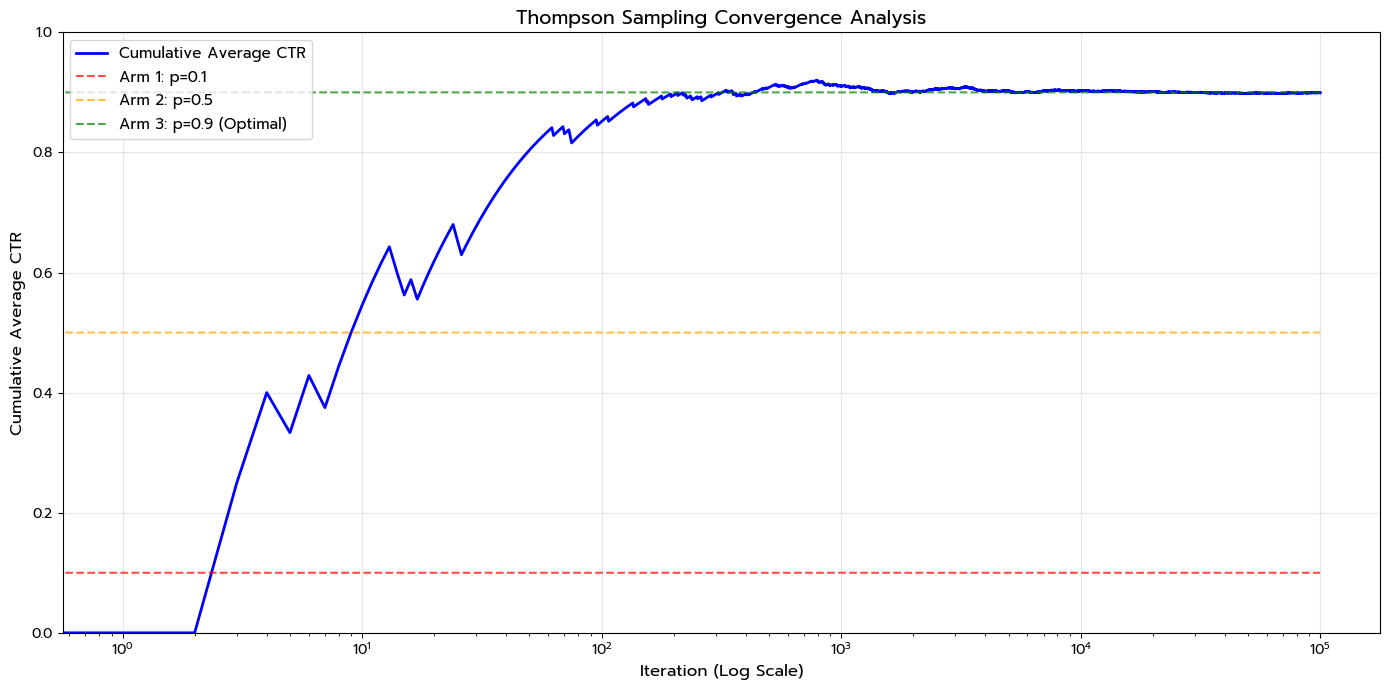


💡 สังเกต:
  - Converge เร็วมาก! (ภายใน 1,000 iterations)
  - เพราะ arms แตกต่างกันชัดเจน → ง่ายต่อการแยก
  - CTR เข้าใกล้ p3 = 0.9 เร็วมาก


In [8]:
print("\n🔬 Experiment 2: Arms ที่แตกต่างกันชัดเจน (0.1, 0.5, 0.9)\n")

# รัน experiment ใหม่
cumulative_avg_2 = run_experiment(p1=0.1, p2=0.5, p3=0.9, N=100000)

print("\n💡 สังเกต:")
print("  - Converge เร็วมาก! (ภายใน 1,000 iterations)")
print("  - เพราะ arms แตกต่างกันชัดเจน → ง่ายต่อการแยก")
print("  - CTR เข้าใกล้ p3 = 0.9 เร็วมาก")

## 📊 Step 8: เปรียบเทียบทั้ง 2 Experiments

มาเปรียบเทียบว่า arms ที่ใกล้กัน vs แตกต่างกัน มีผลต่อ convergence อย่างไร

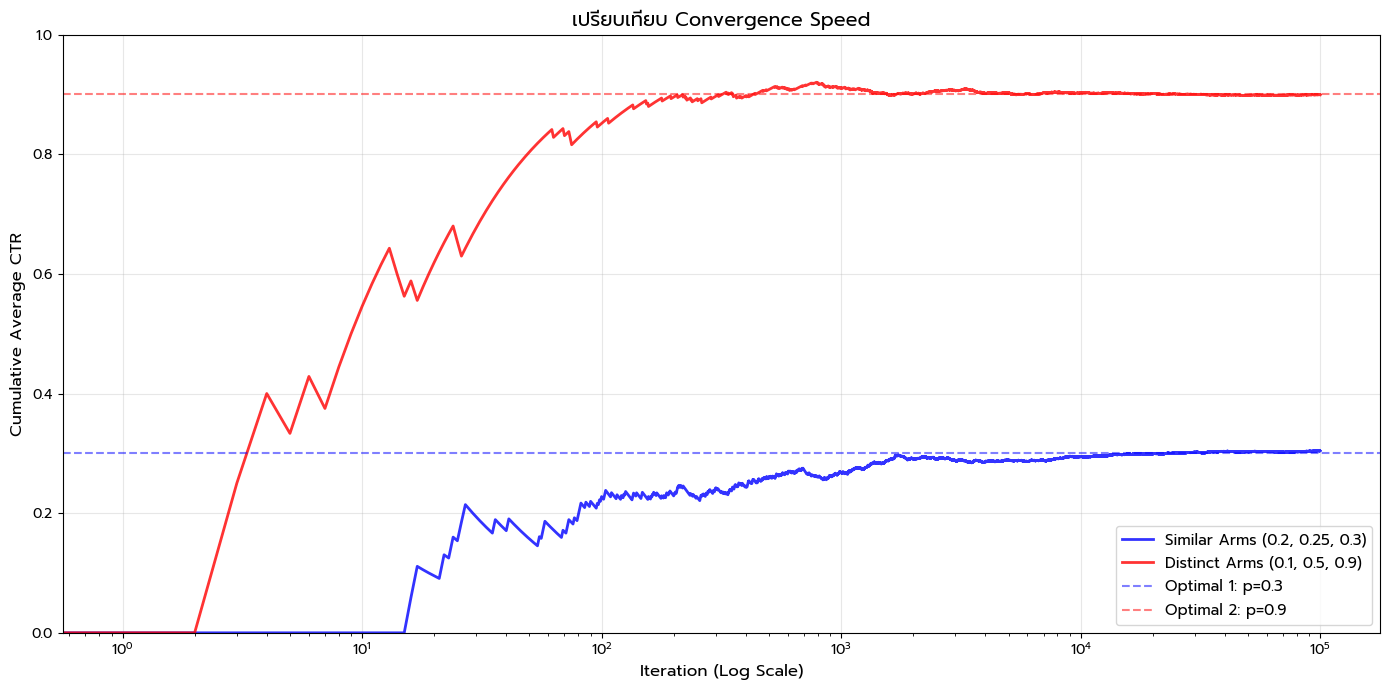


📊 สรุปการเปรียบเทียบ:

1. **Similar Arms (0.2, 0.25, 0.3)**:
   - Converge ช้ากว่า (~10,000 iterations)
   - ต้องใช้ samples มากกว่าเพื่อแยกว่า arm ไหนดีกว่า
   - Final CTR: 0.3041

2. **Distinct Arms (0.1, 0.5, 0.9)**:
   - Converge เร็วมาก (~1,000 iterations)
   - แยก optimal arm ได้ง่าย
   - Final CTR: 0.8993

🎓 ข้อสรุป:
   - Arms ที่แตกต่างกันชัดเจน → Converge เร็ว
   - Arms ที่ใกล้กัน → Converge ช้า (ต้องใช้ samples มากกว่า)
   - Thompson Sampling ปรับตัวได้เองตามความยากของ problem


In [9]:
# วาดกราฟเปรียบเทียบ
plt.figure(figsize=(14, 7))

plt.plot(cumulative_avg, linewidth=2, label='Similar Arms (0.2, 0.25, 0.3)', alpha=0.8, color='blue')
plt.plot(cumulative_avg_2, linewidth=2, label='Distinct Arms (0.1, 0.5, 0.9)', alpha=0.8, color='red')

plt.axhline(0.3, linestyle='--', alpha=0.5, label='Optimal 1: p=0.3', color='blue')
plt.axhline(0.9, linestyle='--', alpha=0.5, label='Optimal 2: p=0.9', color='red')

plt.xlabel('Iteration (Log Scale)', fontsize=12)
plt.ylabel('Cumulative Average CTR', fontsize=12)
plt.title('เปรียบเทียบ Convergence Speed', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xscale('log')
plt.ylim((0, 1))
plt.tight_layout()
plt.show()

print("\n📊 สรุปการเปรียบเทียบ:")
print("\n1. **Similar Arms (0.2, 0.25, 0.3)**:")
print(f"   - Converge ช้ากว่า (~10,000 iterations)")
print(f"   - ต้องใช้ samples มากกว่าเพื่อแยกว่า arm ไหนดีกว่า")
print(f"   - Final CTR: {cumulative_avg[-1]:.4f}")

print("\n2. **Distinct Arms (0.1, 0.5, 0.9)**:")
print(f"   - Converge เร็วมาก (~1,000 iterations)")
print(f"   - แยก optimal arm ได้ง่าย")
print(f"   - Final CTR: {cumulative_avg_2[-1]:.4f}")

print("\n🎓 ข้อสรุป:")
print("   - Arms ที่แตกต่างกันชัดเจน → Converge เร็ว")
print("   - Arms ที่ใกล้กัน → Converge ช้า (ต้องใช้ samples มากกว่า)")
print("   - Thompson Sampling ปรับตัวได้เองตามความยากของ problem")

## 🎓 สรุป: สิ่งที่เราได้เรียนรู้

### 🔑 แนวคิดหลัก (Key Concepts):

#### 1. **Thompson Sampling Algorithm**

**สูตร**:
```
สำหรับแต่ละรอบ t:
  1. Sample θᵢ ~ Beta(aᵢ, bᵢ) สำหรับทุก arm i
  2. เลือก arm j = argmax(θᵢ)
  3. Pull arm j → ได้ reward x ∈ {0, 1}
  4. Update posterior:
     - aⱼ = aⱼ + x
     - bⱼ = bⱼ + (1 - x)
```

**Bayesian Update**:
- Prior: Beta(1, 1) = Uniform(0, 1)
- Likelihood: Bernoulli(p)
- Posterior: Beta(a, b)

#### 2. **Convergence คืออะไร?**

**นิยาม**:
- Algorithm **converge** แปลว่า Cumulative Average CTR → optimal p
- Mathematically: lim(t→∞) avg(t) = p*

**การวัด**:
- **Gap**: |avg(t) - p*|
- **Convergence time**: จำนวน iterations ที่ทำให้ gap < threshold

**ปัจจัยที่ส่งผล**:
1. ความแตกต่างของ arms (ยิ่งชัดเจน → converge เร็ว)
2. จำนวน arms (ยิ่งมาก → converge ช้า)
3. Variance ของ rewards (ยิ่งสูง → converge ช้า)

#### 3. **Log Scale คืออะไร?**

**ทำไมใช้ Log Scale?**
- ✅ เห็นพฤติกรรมช่วงแรก ๆ ชัดเจน (1-100 iterations)
- ✅ เห็นการเปลี่ยนแปลงทุก order of magnitude
- ✅ Convergence มักเป็น exponential → เห็นชัดใน log scale

**การอ่านกราฟ**:
- แกน X: 1, 10, 100, 1K, 10K, 100K
- การเปลี่ยนแปลงช่วงแรก → สำคัญที่สุด
- เมื่อ converge → เส้นกราฟแบน

#### 4. **Cumulative Average**

**สูตร**:
$$
\text{avg}(t) = \frac{1}{t} \sum_{i=1}^{t} r_i = \frac{r_1 + r_2 + \cdots + r_t}{t}
$$

**คุณสมบัติ**:
- เริ่มต้นกระเด้งมาก (variance สูง)
- เมื่อเวลาผ่านไป → stable มากขึ้น
- Converge → optimal average reward

**Incremental Update**:
```python
avg(t) = avg(t-1) + (1/t) * (r_t - avg(t-1))
```

#### 5. **Similar Arms vs Distinct Arms**

| Aspect | Similar Arms (0.2, 0.25, 0.3) | Distinct Arms (0.1, 0.5, 0.9) |
|--------|------------------------------|-------------------------------|
| **Convergence time** | ช้า (~10K iterations) | เร็ว (~1K iterations) |
| **Difficulty** | ยาก (แยกยาก) | ง่าย (แยกง่าย) |
| **Samples needed** | มาก | น้อย |
| **Final CTR** | ≈ 0.30 | ≈ 0.90 |
| **ใช้กับ** | Real-world scenarios | Clear winners |

### 📊 ผลการทดลอง:

**สิ่งที่เห็น**:
1. ✅ Thompson Sampling **converge ไปที่ optimal arm**
2. ✅ Arms ใกล้กัน → Converge ช้า (~10K iterations)
3. ✅ Arms แตกต่างชัด → Converge เร็ว (~1K iterations)
4. ✅ Log scale แสดงพัฒนาการช่วงแรกชัดเจน
5. ✅ Cumulative Average → stable เมื่อเวลาผ่านไป

### 🆚 เปรียบเทียบกับ Epsilon-Greedy:

| Aspect | Thompson Sampling | Epsilon-Greedy |
|--------|-------------------|----------------|
| **Parameter tuning** | ไม่ต้อง ✅ | ต้องตั้ง ε |
| **Adaptation** | Auto-adaptive ✅ | Fixed exploration rate |
| **Convergence** | เร็วกว่า ✅ | ช้ากว่า |
| **Regret bound** | O(log N) ✅ | O(log N) |
| **Implementation** | ซับซ้อนหน่อย | ง่ายมาก |
| **Best for** | Production ✅ | Learning/Testing |

### 🌍 ประยุกต์ใช้:

1. **A/B Testing**:
   - ทดสอบ web designs, features
   - Converge เร็ว → ลด cost of exploration

2. **Online Advertising**:
   - เลือก ads ที่ดีที่สุด
   - Maximize CTR/Revenue

3. **Recommendation Systems**:
   - แนะนำ products, content
   - Personalized recommendations

4. **Clinical Trials**:
   - ทดสอบยา/วิธีรักษา
   - Ethical allocation (ให้ treatment ดีกว่ามากขึ้น)

### 💡 Key Takeaways:

1. **Thompson Sampling converge ไปที่ optimal arm** โดยอัตโนมัติ
2. **ไม่ต้องตั้งพารามิเตอร์** (ไม่เหมือน ε-Greedy)
3. **Arms ใกล้กัน → ใช้เวลานานกว่า** ในการ converge
4. **Log scale สำคัญ** สำหรับการวิเคราะห์ convergence
5. **Cumulative Average** แสดงประสิทธิภาพระยะยาว
6. **Bayesian approach ดีกว่า Frequentist** ในปัญหา sequential decision making

### 🔬 Mathematical Insights:

**Regret Bound**:
```
Expected Regret = O(log N)
```
- N = จำนวนรอบ
- ยิ่ง run นาน → regret เพิ่มช้าลง (logarithmic)

**Posterior Update**:
```
Prior × Likelihood = Posterior
Beta(a, b) × Bernoulli(p) = Beta(a+x, b+1-x)
```

**Beta Distribution Mean**:
```
E[Beta(a, b)] = a / (a + b)
```

### 🔧 Improvements:

1. **Contextual Bandits**:
   - รวม context (user features) เข้ามา
   - ใช้ Linear regression/Neural networks

2. **Non-stationary Environments**:
   - ใช้ Discounted Thompson Sampling
   - Forget old data

3. **Continuous Arms**:
   - ใช้ Gaussian Process
   - Bayesian Optimization

4. **Multiple Objectives**:
   - Multi-objective Thompson Sampling
   - Pareto optimality

---

## 🎉 ยินดีด้วย!

คุณเข้าใจ **Thompson Sampling Convergence** แล้ว!

**Next Steps**:
- เปรียบเทียบ **Thompson Sampling vs UCB**
- ศึกษา **Contextual Bandits**
- ทดลองกับ **Real-world datasets**
- Implement **Production-ready system**

---